In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skfmm

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
# from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.lsm       import LSM

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from kirchhoff import Kirchhoff
from plotting_support import explode_volume

# SETUP - MODEL, REC GEOM, SOURCES

In [2]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [3]:
# Microseismic sources
xmicro = [nx//4, nx//2, 3*(nx//4), ]
ymicro = [ny//4, ny//2, 3*(ny//4), ]
zmicro = [nz//2, nz//2, nz//2, ]
ampmicro = [1,1,1]
ns = len(zmicro)

microseismic = np.zeros((ns, nx, ny, nz))
event_dictionary = []
for ev in range(ns):
    microseismic[ev, xmicro[ev], ymicro[ev], zmicro[ev]] = ampmicro[ev]
    event_dictionary.append({'event':ev,
                             'sx':xmicro[ev],
                             'sy':ymicro[ev],
                             'sz':zmicro[ev],
                             'amp':ampmicro[ev],
                            })

In [4]:
# Define Receiver grid as lines in X and Z
nr_z = 5
nr_x = 5
nr_y = 5
rec_string = '%i-by-%i-by-%i'%(nr_x,nr_y,nr_z)
rec_buffer = 5

# RECEIVER GRID - ONLY ON CUBE SURFACES
grid_z_locs = np.linspace(rec_buffer*dz, (nz-rec_buffer)*dz, nr_z)
grid_x_locs = np.linspace(rec_buffer*dx, (nx-rec_buffer)*dx, nr_x)
grid_y_locs = np.linspace(rec_buffer*dy, (ny-rec_buffer)*dy, nr_y)

F0_rx, F0_ry, F0_rz = np.meshgrid(0,           grid_y_locs, grid_z_locs)      # X face 0 
F1_rx, F1_ry, F1_rz = np.meshgrid(nx*dx,       grid_y_locs, grid_z_locs)      # X face 1 
F2_rx, F2_ry, F2_rz = np.meshgrid(grid_x_locs, 0,           grid_z_locs)      # Y face 0 
F3_rx, F3_ry, F3_rz = np.meshgrid(grid_x_locs, ny*dy,       grid_z_locs)      # Y face 1  
F4_rx, F4_ry, F4_rz = np.meshgrid(grid_x_locs, grid_y_locs, 0)   # Z face 0 
F5_rx, F5_ry, F5_rz = np.meshgrid(grid_x_locs, grid_y_locs, nz*dz)  # Z face 1 

grid_rx = np.vstack([rx.flatten() for rx in [F0_rx,F1_rx,F2_rx,F3_rx,F4_rx,F5_rx,]])
grid_ry = np.vstack([ry.flatten() for ry in [F0_ry,F1_ry,F2_ry,F3_ry,F4_ry,F5_ry,]])
grid_rz = np.vstack([rz.flatten() for rz in [F0_rz,F1_rz,F2_rz,F3_rz,F4_rz,F5_rz,]])
                     
gridded_recs = np.vstack((grid_rx.flatten(), grid_ry.flatten(), grid_rz.flatten()))
nr = gridded_recs.shape[1]

print (nr, gridded_recs.shape)

150 (3, 150)


# MAKE DATA

In [5]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [6]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-2298.0004038464867 - u^H(Op^Hv)=-2298.000403846452


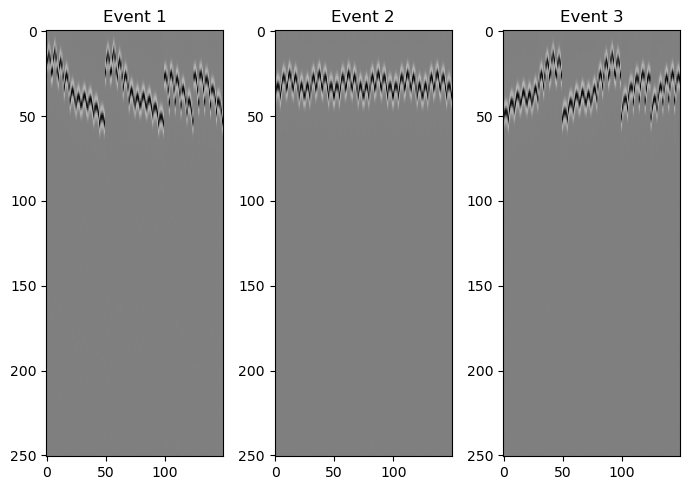

In [7]:
# PERFORM FORWARD (MODEL)
leftEv_fulldata_1d = Op @ microseismic[0].flatten().squeeze()
midEv_fulldata_1d = Op @ microseismic[1].flatten().squeeze()
rightEv_fulldata_1d = Op @ microseismic[2].flatten().squeeze()

leftEv_fulldata  = leftEv_fulldata_1d.reshape(nr,nt)
midEv_fulldata   = midEv_fulldata_1d.reshape(nr,nt)
rightEv_fulldata = rightEv_fulldata_1d.reshape(nr,nt)


fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(leftEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(midEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(rightEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Event 1')
axs[1].set_title('Event 2')
axs[2].set_title('Event 3')
plt.tight_layout()

Text(0.5, 1.0, 'Seismic Recording')

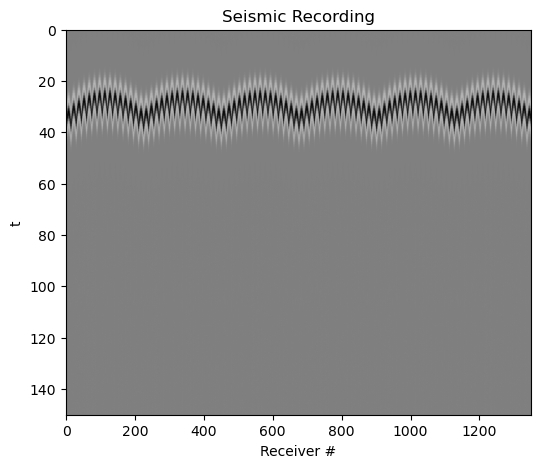

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(midEv_fulldata.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.axis('tight')
ax.set_xlabel('Receiver #')
ax.set_ylabel('t')
ax.set_ylim([150,0])
ax.set_title('Seismic Recording')

In [9]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1_1d = Op.H @ leftEv_fulldata_1d
mig_Ev2_1d = Op.H @ midEv_fulldata_1d
mig_Ev3_1d = Op.H @ rightEv_fulldata_1d

mig_Ev1_pr = mig_Ev1_1d.reshape(nx,ny,nz)
mig_Ev2_pr = mig_Ev2_1d.reshape(nx,ny,nz)
mig_Ev3_pr = mig_Ev3_1d.reshape(nx,ny,nz)

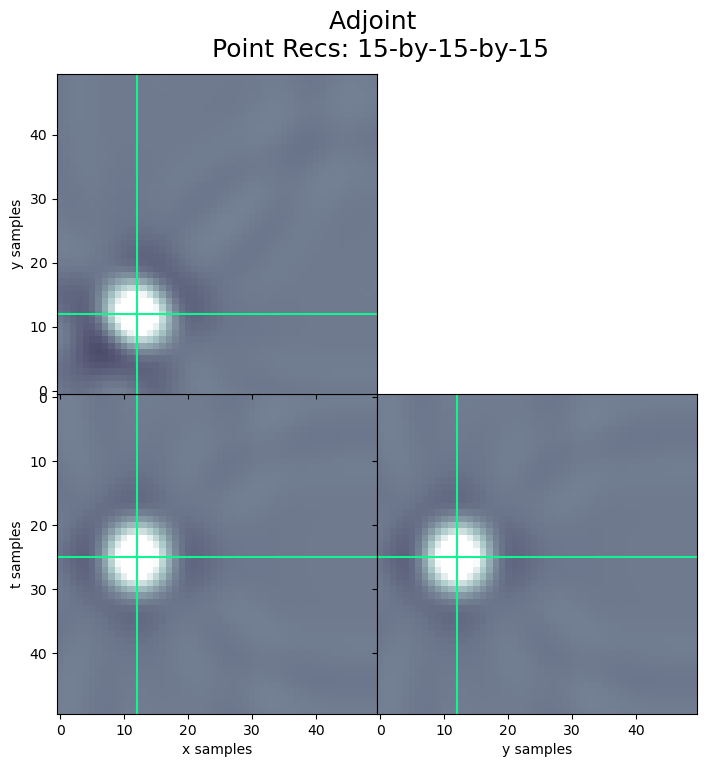

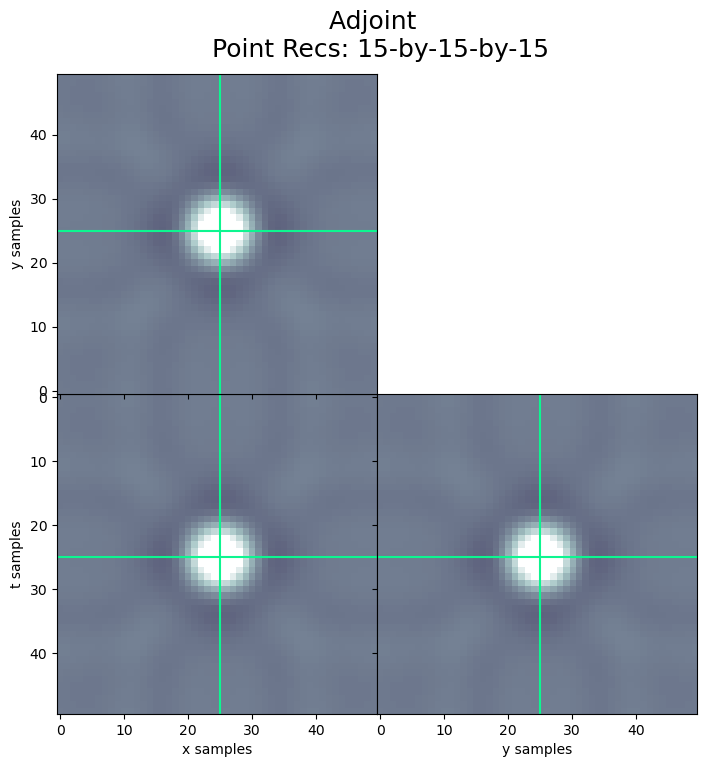

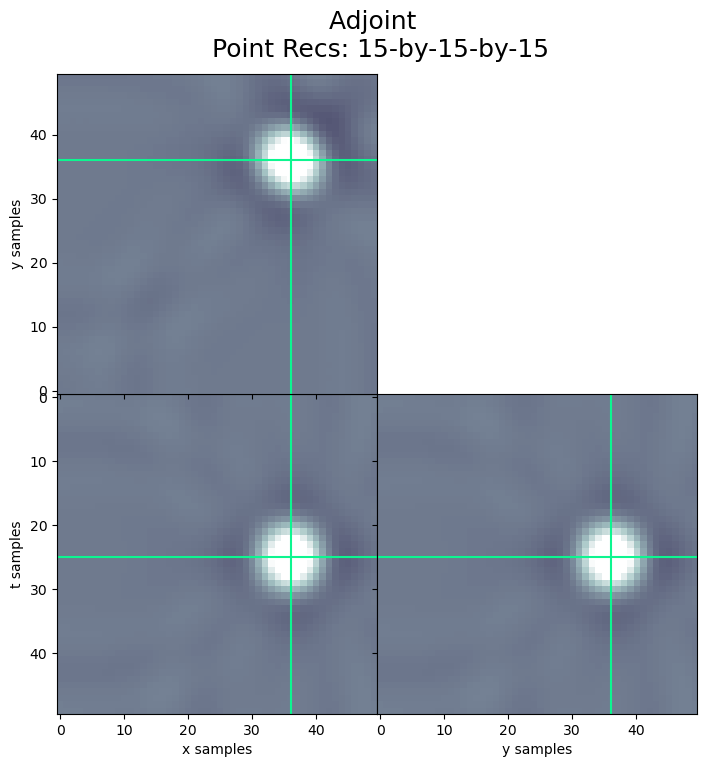

In [10]:
fig,axs = explode_volume(mig_Ev1_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Adjoint \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_Ev2_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[1]['sx'],y=event_dictionary[1]['sy'])
fig.suptitle('Adjoint \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_Ev3_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[2]['sx'],y=event_dictionary[2]['sy'])
fig.suptitle('Adjoint \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()


In [11]:
# PERFORM LSQR
minv_Ev1_1d = lsqr(Op, leftEv_fulldata.ravel(), iter_lim=100, show=True)[0]
minv_Ev2_1d = lsqr(Op, midEv_fulldata.ravel(), iter_lim=100, show=True)[0]
minv_Ev3_1d = lsqr(Op, rightEv_fulldata.ravel(), iter_lim=100, show=True)[0]

minv_Ev1_pr = minv_Ev1_1d.reshape(nx,ny,nz)
minv_Ev2_pr = minv_Ev2_1d.reshape(nx,ny,nz)
minv_Ev3_pr = minv_Ev3_1d.reshape(nx,ny,nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 338850 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   6.928e+01  6.928e+01    1.0e+00  1.3e+01
     1 -4.15030e-05   3.631e+01  3.631e+01    5.2e-01  6.5e-01   1.0e+03  1.0e+00
     2  5.09582e-05   2.431e+01  2.431e+01    3.5e-01  3.5e-01   1.5e+03  2.2e+00
     3  1.45362e-05   1.906e+01  1.906e+01    2.8e-01  2.7e-01   1.7e+03  3.6e+00
     4  2.93476e-05   1.533e+01  1.533e+01    2.2e-01  2.1e-01   2.0e+03  5.2e+00
     5 -5.79569e-06   1.269e+01  1.269e+01    1.8e-01  1.7e-01   2.2e+03  7.1e+00
     6 -7.00310e-06   1.095e+01  1.095e+01    1.6e-01  1.3e-01   2.4e+03  8.9e+00
     7 -4.40675e-05   9.721e+00  9.721e+00    1.4e-01  1.3e-01   2.5e+03  1.1e+01
     8 -6.79288e-05   8.733e+0

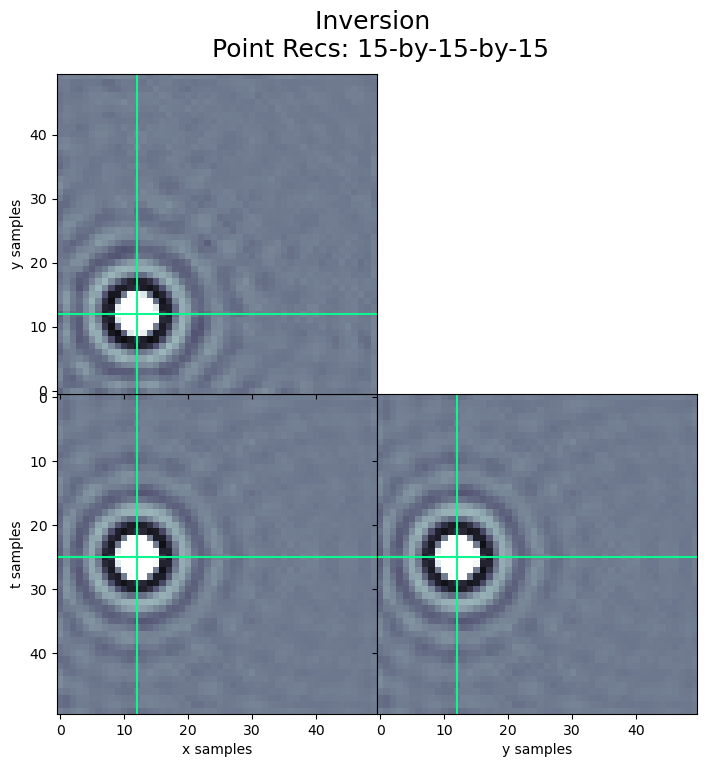

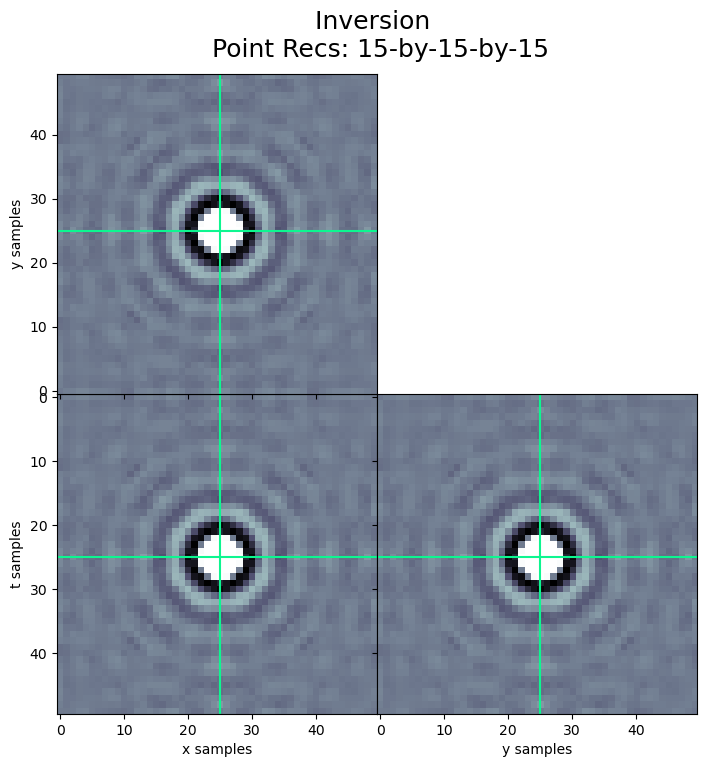

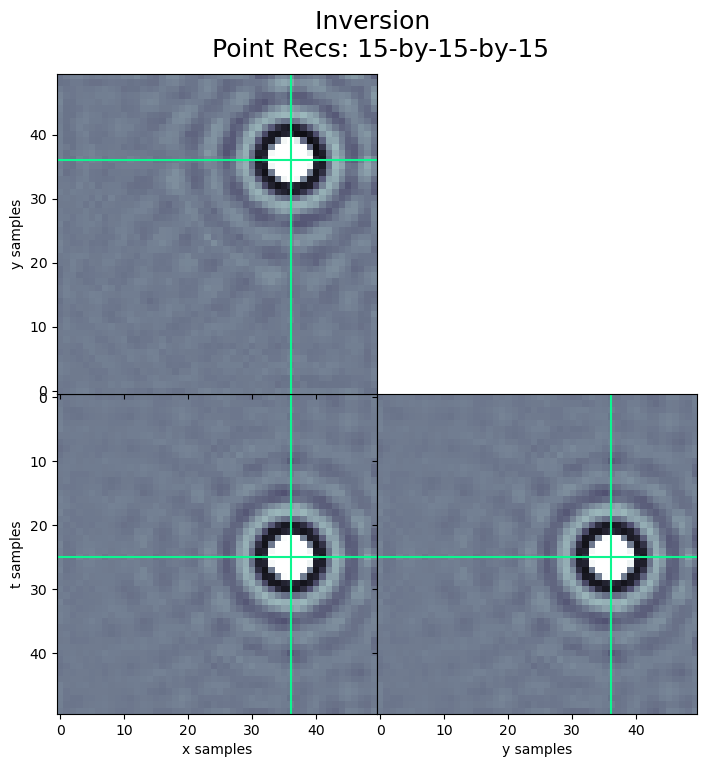

In [12]:
fig,axs = explode_volume(minv_Ev1_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Inversion \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(minv_Ev2_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[1]['sx'],y=event_dictionary[1]['sy'])
fig.suptitle('Inversion \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(minv_Ev3_pr.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[2]['sx'],y=event_dictionary[2]['sy'])
fig.suptitle('Inversion \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()


# IMITATE DAS - NAIVE INVERSE

In [13]:
event = microseismic[1].flatten().squeeze()

In [14]:
face_data = midEv_fulldata.reshape(6,nr_x,nr_x,nt)

In [15]:
face_data = midEv_fulldata.reshape(6,nr_x,nr_x,nt)

face_groupA = face_data[:4]
face_groupB = face_data[2:]
face_groupC = face_data[[1,2,4,5]]

face_groupA_avg = np.repeat(np.sum(face_groupA,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)
face_groupB_avg = np.repeat(np.sum(face_groupB,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)
face_groupC_avg = np.repeat(np.sum(face_groupC,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)

In [16]:
face_groupA.shape

(4, 15, 15, 251)

In [17]:
face_groupA_avg = np.repeat(np.sum(face_groupA,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)
face_groupB_avg = np.repeat(np.sum(face_groupB,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)
face_groupC_avg = np.repeat(np.sum(face_groupC,axis=1), nr_x, axis=1).reshape(4*nr_x*nr_x,nt)

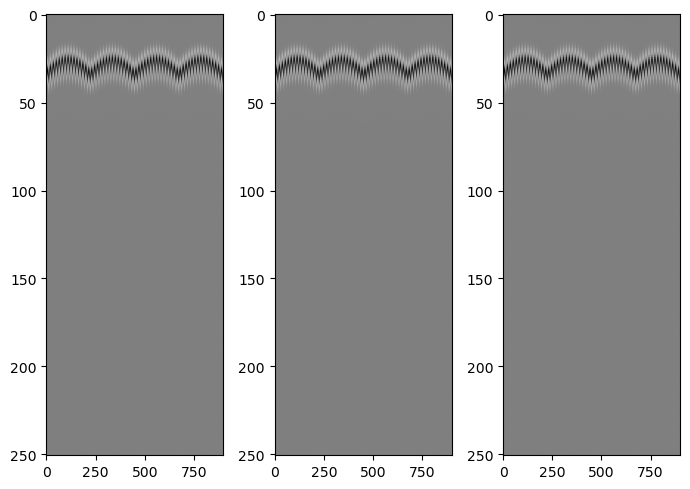

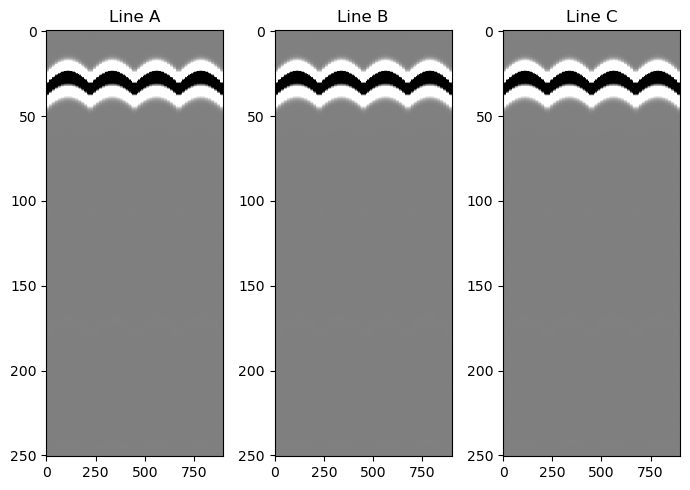

In [18]:
fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(face_groupA.reshape(4*nr_x*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(face_groupB.reshape(4*nr_x*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(face_groupC.reshape(4*nr_x*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(face_groupA_avg.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(face_groupB_avg.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(face_groupC_avg.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[0].set_title('Line A')
axs[1].set_title('Line B')
axs[2].set_title('Line C')
plt.tight_layout()

In [19]:
# V line - Inline: f0-3, group on z
# V line - Crossline: f2-5, group on x
# H line: f0,1,4,5, group on y

# ----------------------------------------------------------------------
#                           VIL
# ----------------------------------------------------------------------
VIL_rx = np.vstack([rx.flatten() for rx in [F0_rx,F1_rx,F2_rx,F3_rx,]])
VIL_ry = np.vstack([ry.flatten() for ry in [F0_ry,F1_ry,F2_ry,F3_ry,]])
VIL_rz = np.vstack([rz.flatten() for rz in [F0_rz,F1_rz,F2_rz,F3_rz,]])              
VIL_recs = np.vstack((VIL_rx.flatten(), VIL_ry.flatten(), VIL_rz.flatten()))

# ----------------------------------------------------------------------
#                           VXL
# ----------------------------------------------------------------------
VXL_rx = np.vstack([rx.flatten() for rx in [F2_rx,F3_rx,F4_rx,F5_rx,]])
VXL_ry = np.vstack([ry.flatten() for ry in [F2_ry,F3_ry,F4_ry,F5_ry,]])
VXL_rz = np.vstack([rz.flatten() for rz in [F2_rz,F3_rz,F4_rz,F5_rz,]])              
VXL_recs = np.vstack((VXL_rx.flatten(), VXL_ry.flatten(), VXL_rz.flatten()))

# ----------------------------------------------------------------------
#                           H
# ----------------------------------------------------------------------
H_rx = np.vstack([rx.flatten() for rx in [F0_rx,F1_rx,F4_rx,F5_rx,]])
H_ry = np.vstack([ry.flatten() for ry in [F0_ry,F1_ry,F4_ry,F5_ry,]])
H_rz = np.vstack([rz.flatten() for rz in [F0_rz,F1_rz,F4_rz,F5_rz,]])              
H_recs = np.vstack((H_rx.flatten(), H_ry.flatten(), H_rz.flatten()))


(3, 2700)


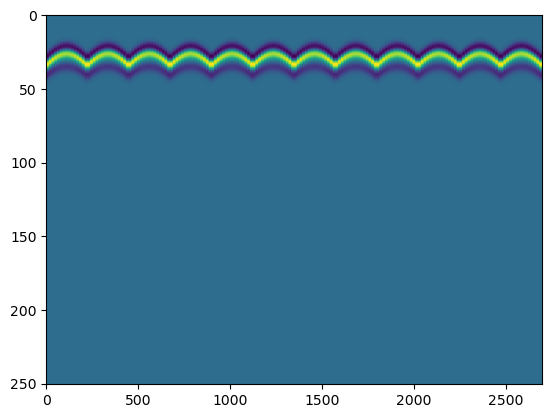

In [20]:
lines_data = np.vstack([face_groupA_avg,face_groupB_avg,face_groupC_avg])
lines_recs = np.hstack([VIL_recs,VXL_recs,H_recs])
print(lines_recs.shape)
plt.imshow(lines_data.T,aspect='auto')

Text(0.5, 1.0, 'Pseudo-DAS')

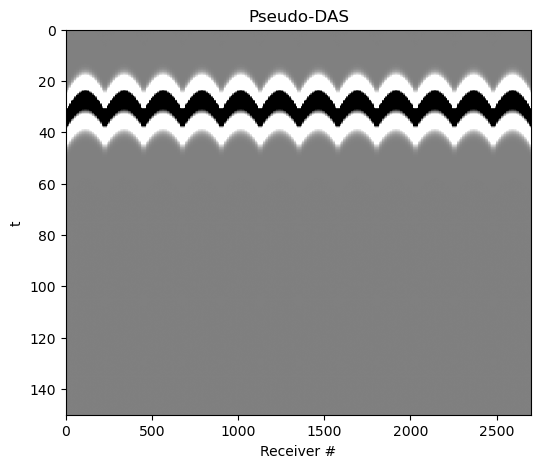

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
im = ax.imshow(lines_data.T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
ax.axis('tight')
ax.set_xlabel('Receiver #')
ax.set_ylabel('t')
ax.set_ylim([150,0])
ax.set_title('Pseudo-DAS')

In [59]:
Op_lines = Kirchhoff(z=z, 
                     x=x, 
                     y=y, 
                     t=t, 
                     srcs=lines_recs[:, :1], 
                     recs=lines_recs, 
                     vel=v0, 
                     wav=wav, 
                     wavcenter=wavc, 
                     mode='analytic', 
                     engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=5365.4539080980685 - u^H(Op^Hv)=5365.453908098055


In [61]:
# PERFORM LSQR
lines_minv_Ev1 = lsqr(Op_lines, lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
lines_minv_Ev2 = lsqr(Op_lines, lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
lines_minv_Ev3 = lsqr(Op_lines, lines_data.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 677700 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.932e+02  7.932e+02    1.0e+00  1.5e+00
     1 -1.46415e-04   3.880e+02  3.880e+02    4.9e-01  5.2e-01   1.4e+03  1.0e+00


SystemError: CPUDispatcher(<function Kirchhoff._travsrcrec_kirch_matvec at 0x151806489940>) returned a result with an error set

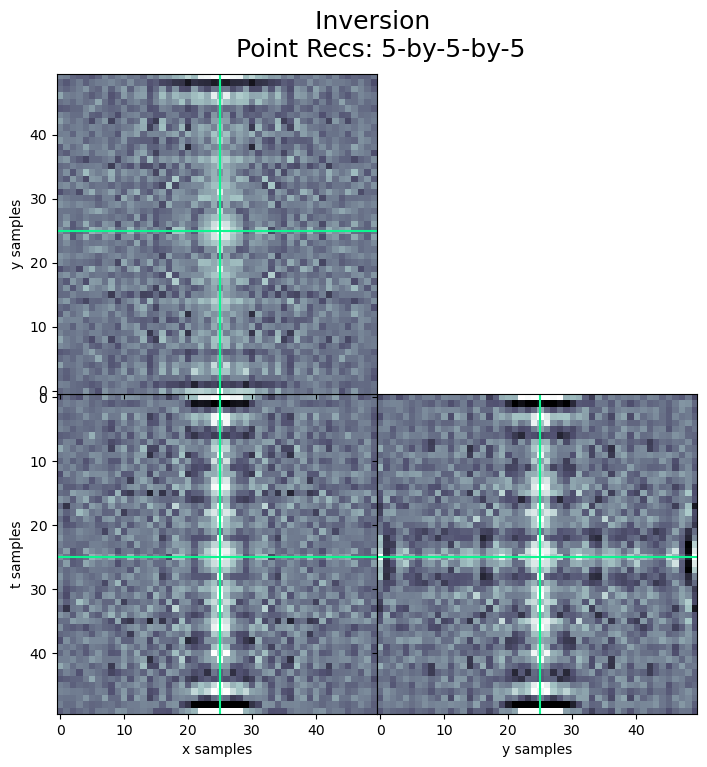

In [62]:
fig,axs = explode_volume(lines_minv.transpose(2,1,0), p=99.9)
fig.suptitle('Inversion \n Point Recs: %s'%rec_string, fontsize=18)
fig.tight_layout()
#                x=73, y=52,
#                tlim=[0, t[-1]], tlabel=r'$t$',
#                    xlim=[x[0]/1e3, x[-1]/1e3], xlabel=r'$x_r$',
#                    ylim=[y[0]/1e3, y[-1]/1e3], ylabel=r'$y_r$',
#                    labels= ('[s]', '[km]', '[km]'),
#                    clipval=(-0.5, 0.5), figsize=(8, 8), 
#                    title='Data')

# SMART INVERSE

In [47]:
# LINE A
RLA_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,2,3],
                      axis=0
                     )
SLA_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# LINE B
RLB_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[2,3,4,5],
                      axis=0
                     )
SLB_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# LINE C
RLC_Op = Restriction(dims=[n_faces, nr_x, nr_x, nt],
                      iava=[0,1,4,5],
                      axis=0
                     )
SLC_Op = Sum((4, nr_x, nr_x, nt), axis=2)

# COMBINING OPERATORS
Vop = VStack([SLA_Op.H @ SLA_Op @ RLA_Op, 
              SLB_Op.H @ SLB_Op @ RLB_Op,
              SLC_Op.H @ SLC_Op @ RLC_Op
             ])

LinesOp = Vop * Op

# check operator with dottest
_ = dottest(LinesOp, verb=True)

Dot test passed, v^H(Opu)=15983.886999114626 - u^H(Op^Hv)=15983.886999114608


In [46]:
n_faces = 6
face_data = midEv_fulldata.reshape(n_faces,nr_x,nr_x,nt)


In [48]:
# FORWARD MODEL DATA USING SUM AND SPREAD
lines_data_op_Ev1 = LinesOp @ microseismic[0].flatten()
lines_data_op_Ev2 = LinesOp @ microseismic[1].flatten()
lines_data_op_Ev3 = LinesOp @ microseismic[2].flatten()

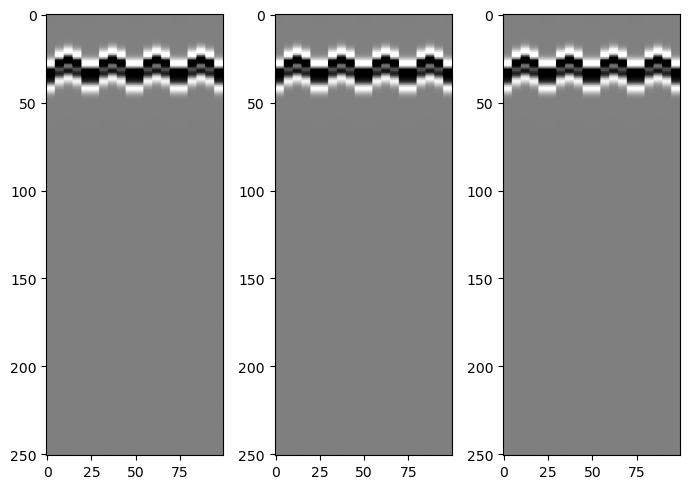

In [49]:
# CHECKING I GET THE DATA I WANT
aveLAdata = SLA_Op.H @ SLA_Op @ RLA_Op @ face_data
aveLBdata = SLB_Op.H @ SLB_Op @ RLB_Op @ face_data
aveLCdata = SLC_Op.H @ SLC_Op @ RLC_Op @ face_data

fig,axs=plt.subplots(1,3,figsize=(7,5))
axs[0].imshow(aveLAdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[1].imshow(aveLBdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
axs[2].imshow(aveLCdata.reshape([4*nr_x*nr_x,nt]).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
plt.tight_layout()

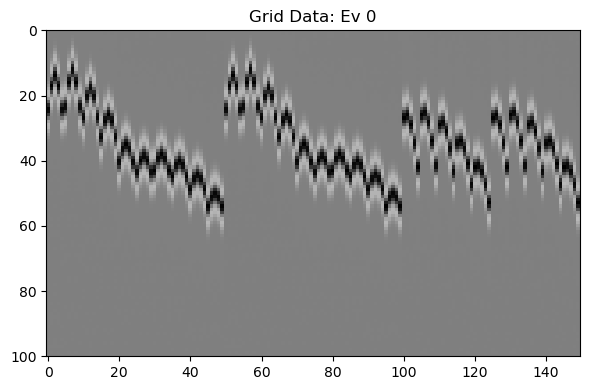

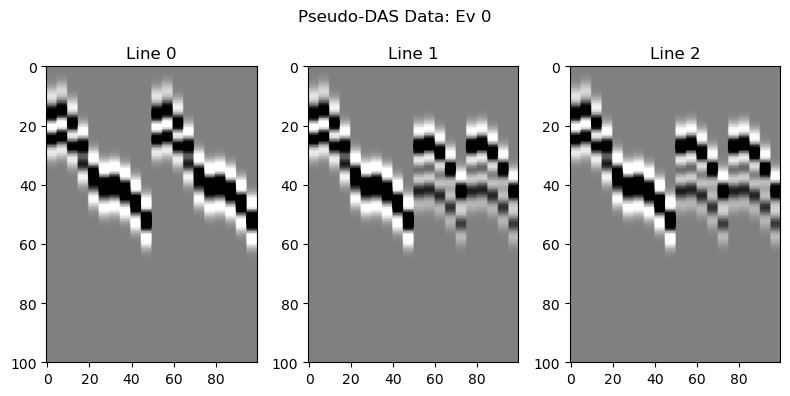

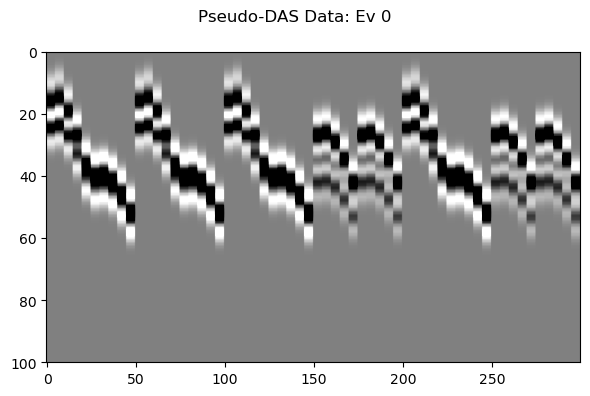

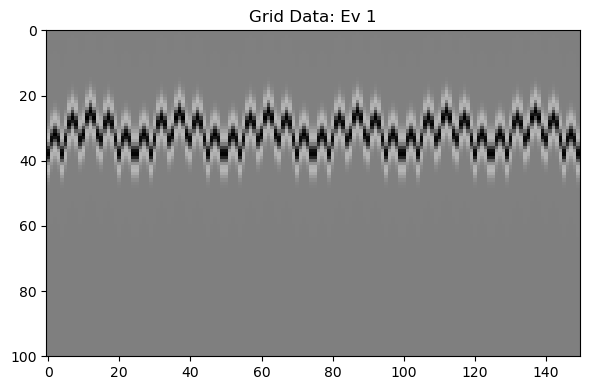

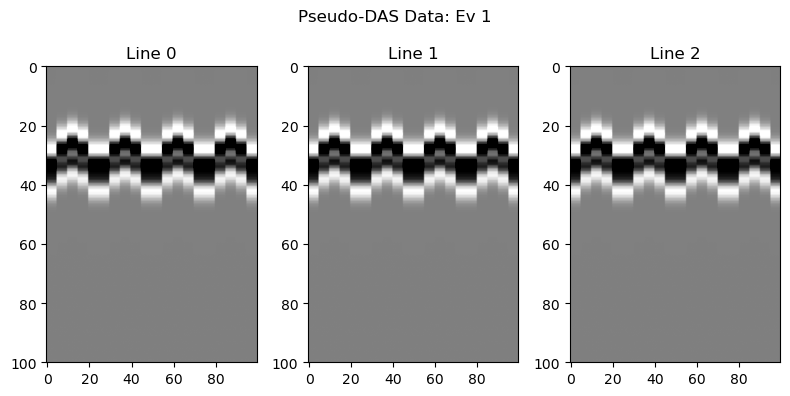

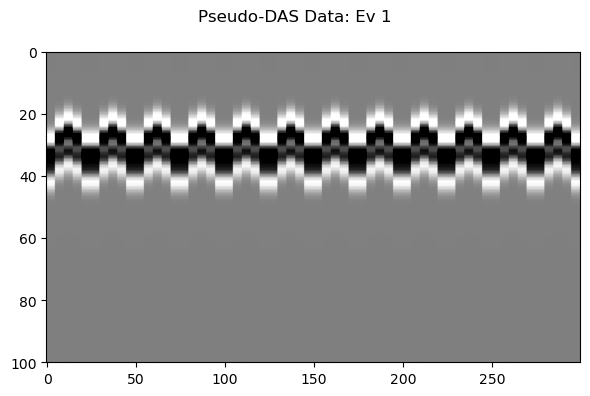

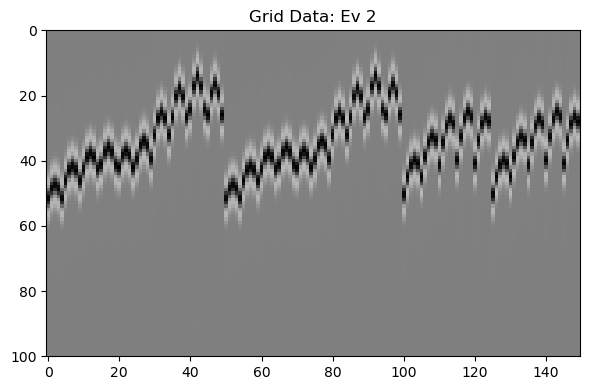

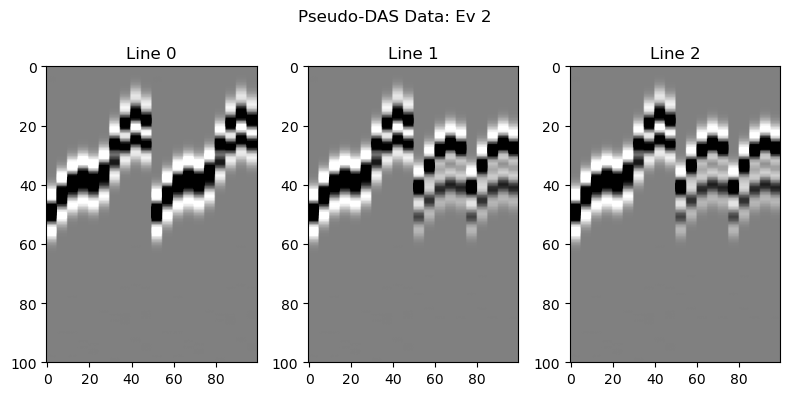

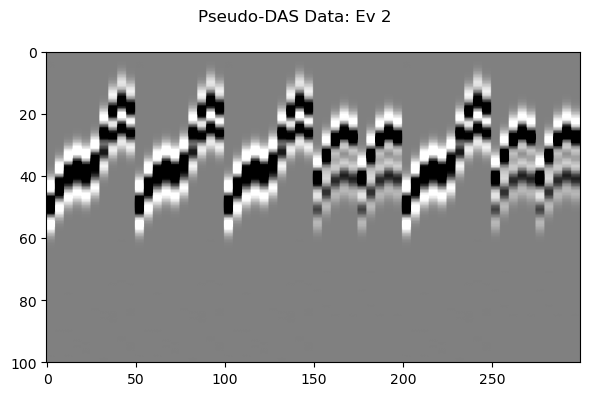

In [76]:
event_data = [leftEv_fulldata, midEv_fulldata, rightEv_fulldata,]

for i,ev in enumerate(event_data):
    aveLAdata = SLA_Op.H @ SLA_Op @ RLA_Op @ ev.reshape(n_faces,nr_x,nr_x,nt)
    aveLBdata = SLB_Op.H @ SLB_Op @ RLB_Op @ ev.reshape(n_faces,nr_x,nr_x,nt)
    aveLCdata = SLC_Op.H @ SLC_Op @ RLC_Op @ ev.reshape(n_faces,nr_x,nr_x,nt)
    lines_data = [aveLAdata, aveLBdata, aveLCdata]
    
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    ax.imshow(ev.reshape(n_faces*nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
    ax.set_ylim([100,0])
    plt.title('Grid Data: Ev %i'%i)
    plt.tight_layout()
    
    fig,axs=plt.subplots(1,3,figsize=(8,4))
    
    for li,line in enumerate(lines_data):
        axs[li].imshow(line.reshape(4*nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
        axs[li].set_ylim([100,0])
        axs[li].set_title('Line %i'%li)
    plt.suptitle('Pseudo-DAS Data: Ev %i'%i)
    plt.tight_layout()
        
    lines_data_op = LinesOp @ microseismic[i].flatten()
    fig,ax=plt.subplots(1,1,figsize=(6,4))
    ax.imshow(lines_data_op.reshape(4*3*nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
    ax.set_ylim([100,0])
    plt.suptitle('Pseudo-DAS Data: Ev %i'%i)
    plt.tight_layout()


# fig,ax=plt.subplots(1,1,figsize=(3,4))
# ax.imshow(xavdata.reshape(nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
# ax.set_ylim([150,0])
# plt.title('Pseudo-DAS: InLines')
# plt.tight_layout()

# fig,ax=plt.subplots(1,1,figsize=(3,4))
# ax.imshow(zavdata.reshape(nr_z*nr_x,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
# ax.set_ylim([150,0])
# plt.title('Pseudo-DAS: CrossLines')
# plt.tight_layout()

# fig,ax=plt.subplots(1,1,figsize=(6,4))
# ax.imshow(lines_data_op.reshape(nr_z*nr_x*2,nt).T, aspect='auto', cmap='binary', vmin=-1, vmax=1)
# ax.set_ylim([150,0])
# plt.title('Pseudo-DAS: Full Data')
# plt.tight_layout()

In [50]:
# PERFORM ADJOINT (MIGRATE)
mig_Ev1_1d = LinesOp.H @ lines_data_op_Ev1
mig_Ev2_1d = LinesOp.H @ lines_data_op_Ev2
mig_Ev3_1d = LinesOp.H @ lines_data_op_Ev3

mig_Ev1_pd = mig_Ev1_1d.reshape(nx,ny,nz)
mig_Ev2_pd = mig_Ev2_1d.reshape(nx,ny,nz)
mig_Ev3_pd = mig_Ev3_1d.reshape(nx,ny,nz)

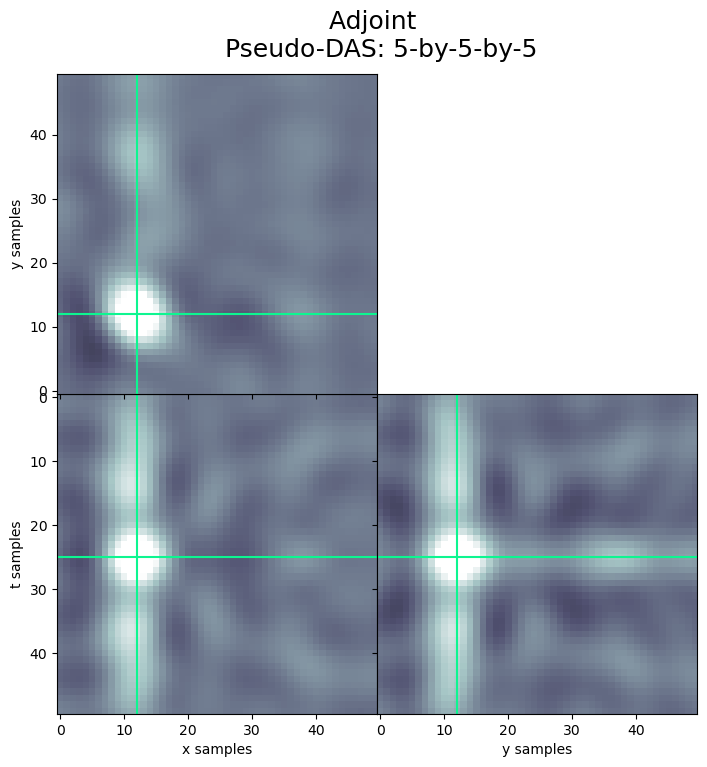

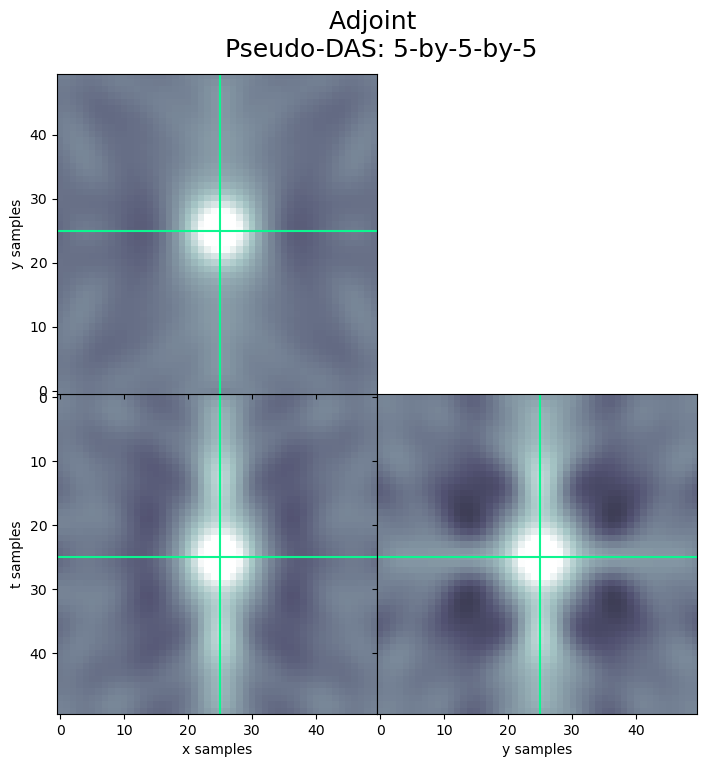

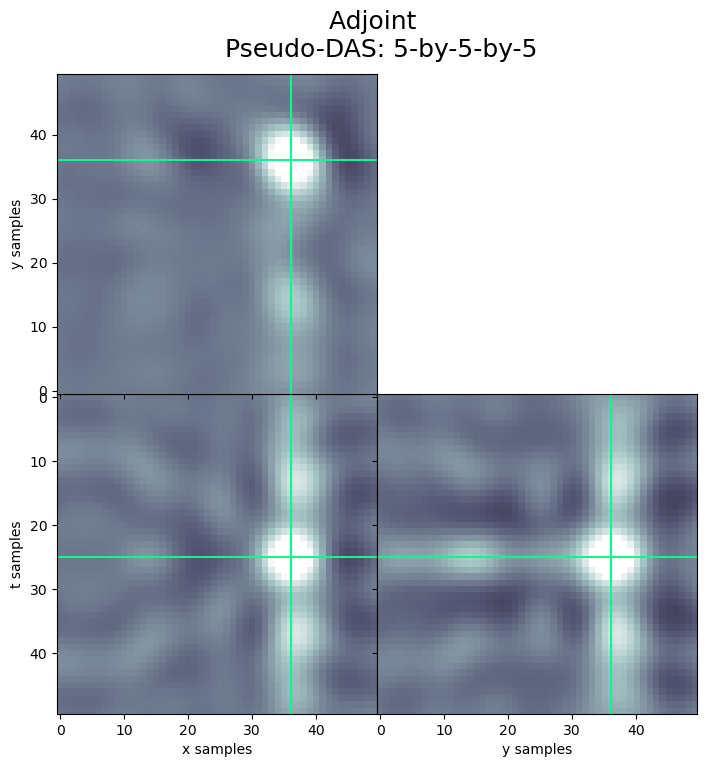

In [51]:
fig,axs = explode_volume(mig_Ev1_pd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Adjoint \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_Ev2_pd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[1]['sx'],y=event_dictionary[1]['sy'])
fig.suptitle('Adjoint \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(mig_Ev3_pd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[2]['sx'],y=event_dictionary[2]['sy'])
fig.suptitle('Adjoint \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()

In [31]:
# PERFORM LSQR
minv_Ev1_ipd = lsqr(LinesOp, lines_data_op_Ev1.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
minv_Ev2_ipd = lsqr(LinesOp, lines_data_op_Ev2.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
minv_Ev3_ipd = lsqr(LinesOp, lines_data_op_Ev3.ravel(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)


 
LSQR            Least-squares solution of  Ax = b
The matrix A has 677700 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.904e+02  7.904e+02    1.0e+00  2.4e+01
     1  5.99751e-06   3.514e+02  3.514e+02    4.4e-01  6.6e-01   2.1e+04  1.0e+00
     2 -4.51878e-05   2.077e+02  2.077e+02    2.6e-01  3.3e-01   2.8e+04  2.2e+00
     3 -2.38110e-05   1.592e+02  1.592e+02    2.0e-01  2.6e-01   3.2e+04  3.5e+00
     4 -3.01717e-06   1.279e+02  1.279e+02    1.6e-01  2.1e-01   3.7e+04  5.1e+00
     5  1.10520e-05   1.056e+02  1.056e+02    1.3e-01  1.7e-01   4.1e+04  6.9e+00
     6  7.86146e-06   9.446e+01  9.446e+01    1.2e-01  1.2e-01   4.4e+04  8.6e+00
     7 -1.86612e-06   8.547e+01  8.547e+01    1.1e-01  1.2e-01   4.8e+04  1.1e+01
     8 -1.67897e-05   7.545e+0

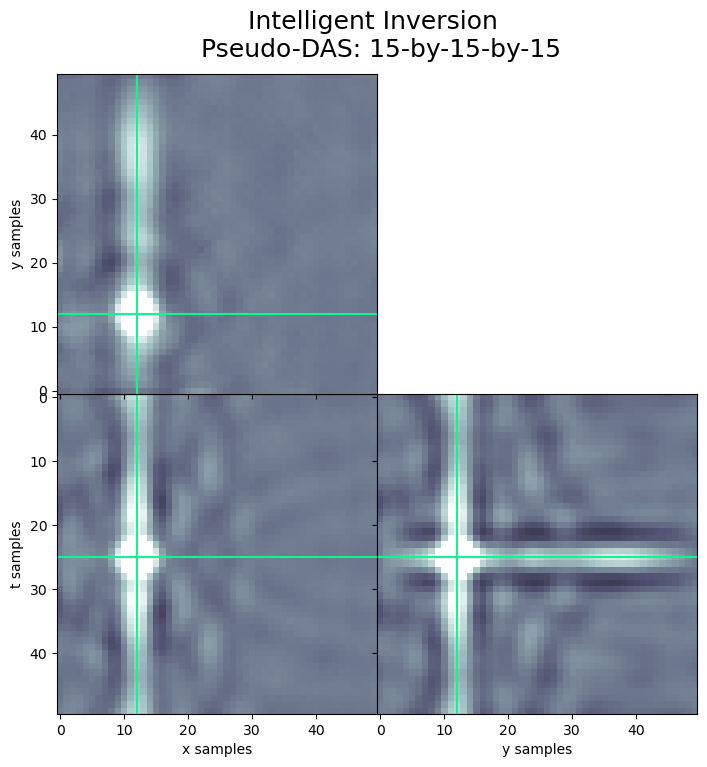

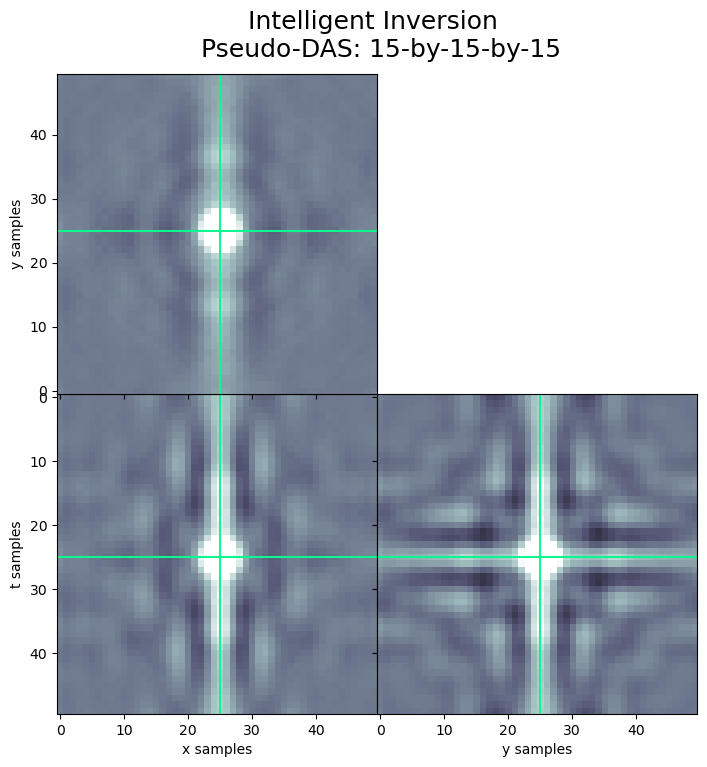

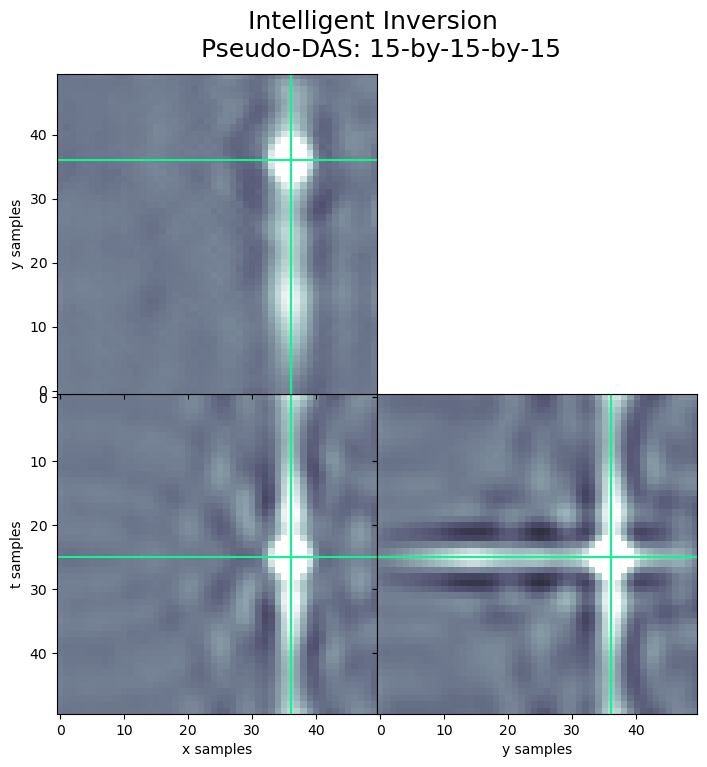

In [32]:
fig,axs = explode_volume(minv_Ev1_ipd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('Intelligent Inversion \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(minv_Ev2_ipd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[1]['sx'],y=event_dictionary[1]['sy'])
fig.suptitle('Intelligent Inversion \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()

fig,axs = explode_volume(minv_Ev3_ipd.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[2]['sx'],y=event_dictionary[2]['sy'])
fig.suptitle('Intelligent Inversion \n Pseudo-DAS: %s'%rec_string, fontsize=18)
fig.tight_layout()


# FISTA

In [56]:
import pylops
epsilon = 1e2
with pylops.disabled_ndarray_multiplication():
    minv_sparse = fista(LinesOp, lines_data_op_Ev1.flatten(), 
                        niter=100, eps=epsilon, show=True)[0].reshape(nx,ny,nz)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 75300 rows and 125000 cols
eps = 1.000000e+02	tol = 1.000000e-10	niter = 100
alpha = 1.322941e-07	thresh = 6.614706e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       2.3317e-05         1.026e+03   1.399e+03   2.133e-02
     2       2.9309e-05         5.592e+02   1.033e+03   8.330e-03
     3       3.4367e-05         3.415e+02   8.692e+02   6.336e-03
     4       4.0497e-05         2.371e+02   7.883e+02   4.892e-03
     5       4.7675e-05         1.825e+02   7.383e+02   3.959e-03
     6       5.4916e-05         1.501e+02   6.997e+02   3.425e-03
     7       6.1085e-05         1.286e+02   6.657e+02   3.143e-03
     8       6.5485e-05         1.133e+02   6.347e+02   2.988e-03
     9       6.7717e-05         1.017e+02   6.065e+02   2.881e-03
    10       

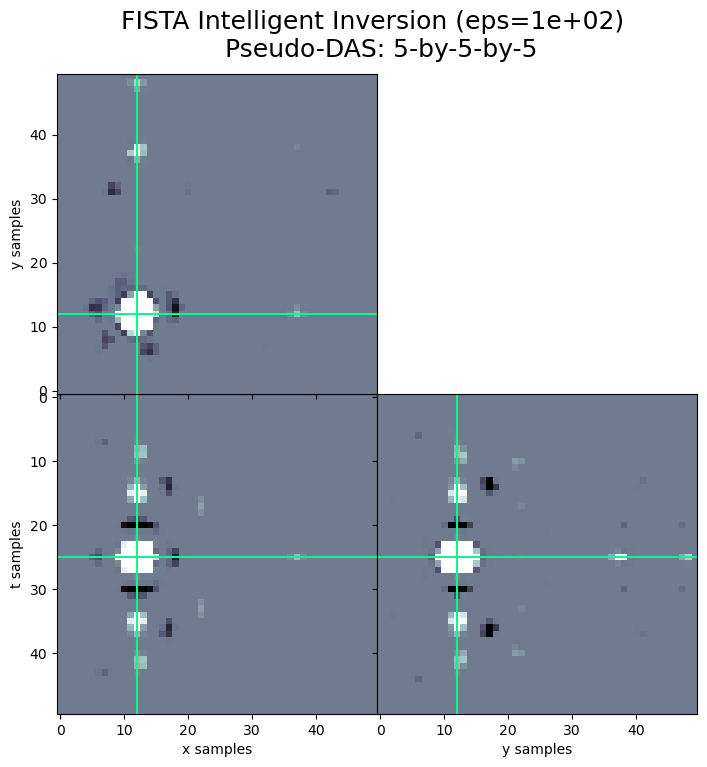

In [57]:
fig,axs = explode_volume(minv_sparse.transpose(2,1,0), p=99.9, 
                         x=event_dictionary[0]['sx'],y=event_dictionary[0]['sy'])
fig.suptitle('FISTA Intelligent Inversion (eps=%.0e) \n Pseudo-DAS: %s'%(epsilon, rec_string), fontsize=18)
fig.tight_layout()
